In [ ]:
""" ADD TO PREDICT - Data_Profiling Notebook"""
# Mount Colab to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
""" ADD TO PREDICT - Data_Profiling Notebook"""
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Installing Java 8
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz # downloading Spark preconfigured with hadoop
!tar xf spark-3.0.2-bin-hadoop3.2.tgz # unzipping spark file
!pip install -q findspark #  install findspark
!pip install xlrd

In [ ]:
""" ADD TO PREDICT - Data_Profiling Notebook"""
import os
# Set the environment variables for JAVA_HOME and SPARK_HOME i.e. setting your spark folder to your system path environment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop3.2"

In [ ]:
""" ADD TO PREDICT - Data_Profiling Notebook"""
# Import and initialize findspark to to make pyspark importable as a regular library and
# creating a Spark Session with a Spark variable
import findspark
findspark.init()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col, to_date, expr

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, TimestampType

In [ ]:
# Set up a SparkSession.
""" ADD TO PREDICT - Data_Profiling Notebook"""
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [ ]:
# Code below uploads file from local machine
from google.colab import files
files.upload()

In [ ]:
df_pandas = pd.read_excel("/content/supply_chain_data.xlsx", engine="openpyxl")

In [ ]:
# Convert Pandas dataframe to Spark dataframe
df_spark = spark.createDataFrame(df_pandas)

/content/spark-3.0.2-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
# Show the data in Spark dataframe
df_spark.show()

+--------------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|      Order ID|         Order Date|Origin Port|Carrier|TPT|Service Level|Ship ahead day count|Ship Late Day count| Customer|Product ID|Plant Code|Destination Port|Unit quantity|           Weight|
+--------------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|1.4472964467E9|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|          808|             14.3|
|1.4471580147E9|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|         3188|            87.94|
|1.4471388987E9

In [ ]:
# Read Excel file into a Pandas dataframe
scd_pd = pd.read_excel("/content/supply_chain_data.xlsx", engine="openpyxl", sheet_name=['OrderList',
'FreightRates',
'WhCosts',
'WhCapacities',
'ProductsPerPlant',
'VmiCustomers',
'PlantPorts'])

In [ ]:
# Assign the different excel sheets from "supply_chain_data.xlsx" workbook into pandas dataframe
ol_df_pd = scd_pd.get('OrderList')
fr_df_pd = scd_pd.get('FreightRates')
wh_costs_df_pd= scd_pd.get('WhCosts')
wh_cap_df_pd= scd_pd.get('WhCapacities')
ppp_df_pd= scd_pd.get('ProductsPerPlant')
vc_df_pd= scd_pd.get('VmiCustomers')
plant_ports_df_pd= scd_pd.get('PlantPorts')

_______________________________________________________________________________

# Outputting **Pandas dataframes** and **schemas**

In [ ]:
# Output schema of 'ol_df_pd' dataframe
print(ol_df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Order ID              9215 non-null   float64       
 1   Order Date            9215 non-null   datetime64[ns]
 2   Origin Port           9215 non-null   object        
 3   Carrier               9215 non-null   object        
 4   TPT                   9215 non-null   int64         
 5   Service Level         9215 non-null   object        
 6   Ship ahead day count  9215 non-null   int64         
 7   Ship Late Day count   9215 non-null   int64         
 8   Customer              9215 non-null   object        
 9   Product ID            9215 non-null   int64         
 10  Plant Code            9215 non-null   object        
 11  Destination Port      9215 non-null   object        
 12  Unit quantity         9215 non-null   int64         
 13  Weight            

In [ ]:
# Outputs "ol_df_pd" dataframe
print(ol_df_pd)

          Order ID Order Date Origin Port Carrier  TPT Service Level  \
0     1.447296e+09 2013-05-26      PORT09   V44_3    1           CRF   
1     1.447158e+09 2013-05-26      PORT09   V44_3    1           CRF   
2     1.447139e+09 2013-05-26      PORT09   V44_3    1           CRF   
3     1.447364e+09 2013-05-26      PORT09   V44_3    1           CRF   
4     1.447364e+09 2013-05-26      PORT09   V44_3    1           CRF   
...            ...        ...         ...     ...  ...           ...   
9210  1.447305e+09 2013-05-26      PORT04  V444_1    1           DTD   
9211  1.447319e+09 2013-05-26      PORT04  V444_1    1           DTD   
9212  1.447322e+09 2013-05-26      PORT04  V444_1    1           DTD   
9213  1.447145e+09 2013-05-26      PORT04  V444_1    1           DTD   
9214  1.447328e+09 2013-05-26      PORT04  V444_1    1           DTD   

      Ship ahead day count  Ship Late Day count           Customer  \
0                        3                    0          V55555_5

In [ ]:
# Output schema of 'fr_df_pd' dataframe
print(fr_df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Carrier       1540 non-null   object 
 1   orig_port_cd  1540 non-null   object 
 2   dest_port_cd  1540 non-null   object 
 3   minm_wgh_qty  1540 non-null   float64
 4   max_wgh_qty   1540 non-null   float64
 5   svc_cd        1540 non-null   object 
 6   minimum cost  1540 non-null   float64
 7   rate          1540 non-null   float64
 8   mode_dsc      1540 non-null   object 
 9   tpt_day_cnt   1540 non-null   int64  
 10  Carrier type  1540 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 132.5+ KB
None


In [ ]:
# Outputs "ol_df_pd" dataframe
print(fr_df_pd)

     Carrier orig_port_cd dest_port_cd  minm_wgh_qty  max_wgh_qty svc_cd  \
0     V444_6       PORT08       PORT09         250.0       499.99    DTD   
1     V444_6       PORT08       PORT09          65.0        69.99    DTD   
2     V444_6       PORT08       PORT09          60.0        64.99    DTD   
3     V444_6       PORT08       PORT09          50.0        54.99    DTD   
4     V444_6       PORT08       PORT09          35.0        39.99    DTD   
...      ...          ...          ...           ...          ...    ...   
1535  V444_8       PORT03       PORT09           0.0        99.99    DTD   
1536  V444_8       PORT03       PORT09         500.0      1999.99    DTD   
1537  V444_8       PORT03       PORT09         250.0       499.99    DTD   
1538  V444_8       PORT03       PORT09        2000.0     99999.99    DTD   
1539  V444_8       PORT03       PORT09         100.0       249.99    DTD   

      minimum cost    rate mode_dsc  tpt_day_cnt Carrier type  
0          43.2272  0.7

In [ ]:
# Schema of dataframe
print(wh_costs_df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WH         19 non-null     object 
 1   Cost/unit  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes
None


In [ ]:
# Outputs of dataframe
print(wh_costs_df_pd)

         WH  Cost/unit
0   PLANT15   1.415063
1   PLANT17   0.428947
2   PLANT18   2.036254
3   PLANT05   0.488144
4   PLANT02   0.477504
5   PLANT01   0.566976
6   PLANT06   0.554088
7   PLANT10   0.493582
8   PLANT07   0.371424
9   PLANT14   0.634330
10  PLANT16   1.919808
11  PLANT12   0.773132
12  PLANT11   0.555247
13  PLANT09   0.465071
14  PLANT03   0.517502
15  PLANT13   0.469707
16  PLANT19   0.639763
17  PLANT08   0.522857
18  PLANT04   0.428503


In [ ]:
# Schema of dataframe
print(wh_cap_df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Plant ID         19 non-null     object
 1   Daily Capacity   19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes
None


In [ ]:
# Outputs of dataframe
print(wh_cap_df_pd)

   Plant ID  Daily Capacity 
0   PLANT15               11
1   PLANT17                8
2   PLANT18              111
3   PLANT05              385
4   PLANT02              138
5   PLANT01             1070
6   PLANT06               49
7   PLANT10              118
8   PLANT07              265
9   PLANT14              549
10  PLANT16              457
11  PLANT12              209
12  PLANT11              332
13  PLANT09               11
14  PLANT03             1013
15  PLANT13              490
16  PLANT19                7
17  PLANT08               14
18  PLANT04              554


In [ ]:
# Schema of dataframe
print(ppp_df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Plant Code  2036 non-null   object
 1   Product ID  2036 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.9+ KB
None


In [ ]:
# Outputs of dataframe
print(ppp_df_pd)

     Plant Code  Product ID
0       PLANT15     1698815
1       PLANT17     1664419
2       PLANT17     1664426
3       PLANT17     1672826
4       PLANT17     1674916
...         ...         ...
2031    PLANT04     1699951
2032    PLANT04     1699952
2033    PLANT04     1699953
2034    PLANT04     1699954
2035    PLANT04     1699974

[2036 rows x 2 columns]


In [ ]:
# Schema of dataframe
print(vc_df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Plant Code  14 non-null     object
 1   Customers   14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes
None


In [ ]:
# Outputs of dataframe
print(vc_df_pd)

   Plant Code                Customers
0     PLANT02        V5555555555555_16
1     PLANT02      V555555555555555_29
2     PLANT02             V555555555_3
3     PLANT02        V55555555555555_8
4     PLANT02              V55555555_9
5     PLANT02                V55555_10
6     PLANT02              V55555555_5
7     PLANT06      V555555555555555_18
8     PLANT06                V55555_10
9     PLANT10      V555555555555555_29
10    PLANT10               V555555_34
11    PLANT10  V5555555555555555555_54
12    PLANT10                V55555_10
13    PLANT11  V5555555555555555555_54


In [ ]:
# Schema of dataframe
print(plant_ports_df_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Plant Code  22 non-null     object
 1   Port        22 non-null     object
dtypes: object(2)
memory usage: 480.0+ bytes
None


In [ ]:
# Outputs of dataframe
print(plant_ports_df_pd)

   Plant Code    Port
0     PLANT01  PORT01
1     PLANT01  PORT02
2     PLANT02  PORT03
3     PLANT03  PORT04
4     PLANT04  PORT05
5     PLANT05  PORT06
6     PLANT06  PORT06
7     PLANT07  PORT01
8     PLANT07  PORT02
9     PLANT08  PORT04
10    PLANT09  PORT04
11    PLANT10  PORT01
12    PLANT10  PORT02
13    PLANT11  PORT04
14    PLANT12  PORT04
15    PLANT13  PORT04
16    PLANT14  PORT07
17    PLANT15  PORT08
18    PLANT16  PORT09
19    PLANT17  PORT10
20    PLANT18  PORT11
21    PLANT19  PORT04


In [ ]:
# ol_df = df_pd.get('OrderList')
# fr_df = df_pd.get('FreightRates')
# wh_costs_df= df_pd.get('WhCosts')
# wh_cap_df= df_pd.get('WhCapacities')
# ppp_df= df_pd.get('ProductsPerPlant')
# vc_df= df_pd.get('VmiCustomers')
# plant_ports_df= df_pd.get('PlantPorts')

In [ ]:
# Convert Pandas dataframe to Spark dataframe
df_spark_ol = spark.createDataFrame(ol_df_pd)
df_spark_fr = spark.createDataFrame(fr_df_pd)
df_spark_whCosts = spark.createDataFrame(wh_costs_df_pd)
df_spark_whCap = spark.createDataFrame(wh_cap_df_pd)
df_spark_ppp = spark.createDataFrame(ppp_df_pd)
df_spark_vc = spark.createDataFrame(vc_df_pd)
df_spark_plant_ports = spark.createDataFrame(plant_ports_df_pd)

/content/spark-3.0.2-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


_______________________________________________________________________________

# Outputting converted **Pandas dataframe** to **Spark dataframe**

In [ ]:
df_spark_ol.show()

+--------------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|      Order ID|         Order Date|Origin Port|Carrier|TPT|Service Level|Ship ahead day count|Ship Late Day count| Customer|Product ID|Plant Code|Destination Port|Unit quantity|           Weight|
+--------------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|1.4472964467E9|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|          808|             14.3|
|1.4471580147E9|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|         3188|            87.94|
|1.4471388987E9

In [ ]:
df_spark_fr.show()

+-------+------------+------------+------------+-----------+------+------------------+------------------+--------+-----------+------------+
|Carrier|orig_port_cd|dest_port_cd|minm_wgh_qty|max_wgh_qty|svc_cd|      minimum cost|              rate|mode_dsc|tpt_day_cnt|Carrier type|
+-------+------------+------------+------------+-----------+------+------------------+------------------+--------+-----------+------------+
| V444_6|      PORT08|      PORT09|       250.0|     499.99|   DTD|43.227199999999996|            0.7132|  AIR   |          2| V88888888_0|
| V444_6|      PORT08|      PORT09|        65.0|      69.99|   DTD|43.227199999999996|0.7512000000000001|  AIR   |          2| V88888888_0|
| V444_6|      PORT08|      PORT09|        60.0|      64.99|   DTD|43.227199999999996|            0.7892|  AIR   |          2| V88888888_0|
| V444_6|      PORT08|      PORT09|        50.0|      54.99|   DTD|43.227199999999996|0.8271999999999999|  AIR   |          2| V88888888_0|
| V444_6|      PORT0

In [ ]:
# df_spark_ol
# df_spark_fr
# df_spark_whCosts
# df_spark_whCap
# df_spark_ppp
# df_spark_vc
# df_spark_plant_ports

In [ ]:
df_spark_whCosts.show()

+-------+-------------------+
|     WH|          Cost/unit|
+-------+-------------------+
|PLANT15| 1.4150633766876566|
|PLANT17|0.42894658708921174|
|PLANT18| 2.0362537598033468|
|PLANT05|0.48814438452738274|
|PLANT02| 0.4775035189272224|
|PLANT01| 0.5669761849295618|
|PLANT06| 0.5540880976257885|
|PLANT10| 0.4935818984829453|
|PLANT07|  0.371423937425446|
|PLANT14| 0.6343297377046666|
|PLANT16| 1.9198075078524335|
|PLANT12| 0.7731317943178858|
|PLANT11| 0.5552472904512042|
|PLANT09|0.46507109738293506|
|PLANT03| 0.5175018916254618|
|PLANT13|0.46970705658151307|
|PLANT19| 0.6397625198174935|
|PLANT08| 0.5228572991962216|
|PLANT04|0.42850329514821733|
+-------+-------------------+



In [ ]:
df_spark_whCap.show()

+--------+---------------+
|Plant ID|Daily Capacity |
+--------+---------------+
| PLANT15|             11|
| PLANT17|              8|
| PLANT18|            111|
| PLANT05|            385|
| PLANT02|            138|
| PLANT01|           1070|
| PLANT06|             49|
| PLANT10|            118|
| PLANT07|            265|
| PLANT14|            549|
| PLANT16|            457|
| PLANT12|            209|
| PLANT11|            332|
| PLANT09|             11|
| PLANT03|           1013|
| PLANT13|            490|
| PLANT19|              7|
| PLANT08|             14|
| PLANT04|            554|
+--------+---------------+



In [ ]:
df_spark_ppp.show()

+----------+----------+
|Plant Code|Product ID|
+----------+----------+
|   PLANT15|   1698815|
|   PLANT17|   1664419|
|   PLANT17|   1664426|
|   PLANT17|   1672826|
|   PLANT17|   1674916|
|   PLANT17|   1674918|
|   PLANT17|   1675507|
|   PLANT17|   1676151|
|   PLANT17|   1676152|
|   PLANT17|   1677864|
|   PLANT17|   1677865|
|   PLANT17|   1679124|
|   PLANT17|   1685369|
|   PLANT17|   1685370|
|   PLANT17|   1685378|
|   PLANT17|   1685979|
|   PLANT17|   1691969|
|   PLANT17|   1694139|
|   PLANT17|   1694217|
|   PLANT17|   1696107|
+----------+----------+
only showing top 20 rows



In [ ]:
df_spark_vc.show()

+----------+--------------------+
|Plant Code|           Customers|
+----------+--------------------+
|   PLANT02|   V5555555555555_16|
|   PLANT02| V555555555555555_29|
|   PLANT02|        V555555555_3|
|   PLANT02|   V55555555555555_8|
|   PLANT02|         V55555555_9|
|   PLANT02|           V55555_10|
|   PLANT02|         V55555555_5|
|   PLANT06| V555555555555555_18|
|   PLANT06|           V55555_10|
|   PLANT10| V555555555555555_29|
|   PLANT10|          V555555_34|
|   PLANT10|V5555555555555555...|
|   PLANT10|           V55555_10|
|   PLANT11|V5555555555555555...|
+----------+--------------------+



In [ ]:
df_spark_plant_ports.show()

+----------+------+
|Plant Code|  Port|
+----------+------+
|   PLANT01|PORT01|
|   PLANT01|PORT02|
|   PLANT02|PORT03|
|   PLANT03|PORT04|
|   PLANT04|PORT05|
|   PLANT05|PORT06|
|   PLANT06|PORT06|
|   PLANT07|PORT01|
|   PLANT07|PORT02|
|   PLANT08|PORT04|
|   PLANT09|PORT04|
|   PLANT10|PORT01|
|   PLANT10|PORT02|
|   PLANT11|PORT04|
|   PLANT12|PORT04|
|   PLANT13|PORT04|
|   PLANT14|PORT07|
|   PLANT15|PORT08|
|   PLANT16|PORT09|
|   PLANT17|PORT10|
+----------+------+
only showing top 20 rows



_______________________________________________________________________________

# **Summary statistics of each Spark dataframe (before data quality checks)**

#####1. Order List

In [ ]:
df_spark_ol.describe().show()

+-------+--------------------+-----------+-------+------------------+-------------+--------------------+-------------------+--------------------+------------------+----------+----------------+------------------+------------------+
|summary|            Order ID|Origin Port|Carrier|               TPT|Service Level|Ship ahead day count|Ship Late Day count|            Customer|        Product ID|Plant Code|Destination Port|     Unit quantity|            Weight|
+-------+--------------------+-----------+-------+------------------+-------------+--------------------+-------------------+--------------------+------------------+----------+----------------+------------------+------------------+
|  count|                9215|       9215|   9215|              9215|         9215|                9215|               9215|                9215|              9215|      9215|            9215|              9215|              9215|
|   mean|1.4472736988818884E9|       null|   null|1.7177428106348345|       

#####2. Freight Reights


In [ ]:
df_spark_fr.describe().show()

+-------+-------+------------+------------+------------------+------------------+------+------------------+------------------+--------+------------------+------------+
|summary|Carrier|orig_port_cd|dest_port_cd|      minm_wgh_qty|       max_wgh_qty|svc_cd|      minimum cost|              rate|mode_dsc|       tpt_day_cnt|Carrier type|
+-------+-------+------------+------------+------------------+------------------+------+------------------+------------------+--------+------------------+------------+
|  count|   1540|        1540|        1540|              1540|              1540|  1540|              1540|              1540|    1540|              1540|        1540|
|   mean|   null|        null|        null|155.88663687532483|  4636.14363302864|  null|12.329032711688322|  2.89265585697203|    null|2.1863636363636365|        null|
| stddev|   null|        null|        null| 475.9520491625025|20251.309727377837|  null|22.946192320029418| 4.603877372494976|    null|2.0008954519721818|      

#####3. Weight Costs

In [ ]:
df_spark_whCosts.describe().show()

+-------+-------+-------------------+
|summary|     WH|          Cost/unit|
+-------+-------+-------------------+
|  count|     19|                 19|
|   mean|   null| 0.7241000650303471|
| stddev|   null|0.49509051350306943|
|    min|PLANT01|  0.371423937425446|
|    max|PLANT19| 2.0362537598033468|
+-------+-------+-------------------+



#####4. Weight Capacities

In [ ]:
df_spark_whCap.describe().show()

+-------+--------+-----------------+
|summary|Plant ID|  Daily Capacity |
+-------+--------+-----------------+
|  count|      19|               19|
|   mean|    null|304.7894736842105|
| stddev|    null| 323.513279642835|
|    min| PLANT01|                7|
|    max| PLANT19|             1070|
+-------+--------+-----------------+



#####5. Products per Plant

In [ ]:
df_spark_ppp.describe().show()

+-------+----------+------------------+
|summary|Plant Code|        Product ID|
+-------+----------+------------------+
|  count|      2036|              2036|
|   mean|      null|1684179.8860510807|
| stddev|      null|13148.043792194074|
|    min|      CND9|           1613321|
|    max|   PLANT18|           1702654|
+-------+----------+------------------+



### **Ran summary statistics for the below 2 dataframes for the sake of completion, although it's actually incorrect. As the entities of the dataframe attributes represent qualitative data, hence the null values**

#####6. Vendor-Managed Inventory Customers (Vmi)

In [ ]:
df_spark_vc.describe().show()

+-------+----------+--------------------+
|summary|Plant Code|           Customers|
+-------+----------+--------------------+
|  count|        14|                  14|
|   mean|      null|                null|
| stddev|      null|                null|
|    min|   PLANT02|V5555555555555555...|
|    max|   PLANT11|           V55555_10|
+-------+----------+--------------------+



#####7. Plant Ports

In [ ]:
df_spark_plant_ports.describe().show()

+-------+----------+------+
|summary|Plant Code|  Port|
+-------+----------+------+
|  count|        22|    22|
|   mean|      null|  null|
| stddev|      null|  null|
|    min|   PLANT01|PORT01|
|    max|   PLANT19|PORT11|
+-------+----------+------+



In [ ]:
# df_spark_ol
# df_spark_fr
# df_spark_whCosts
# df_spark_whCap
# df_spark_ppp
# df_spark_vc
# df_spark_plant_ports

_______________________________________________________________________________

# **Update column names**
To make the data easier to work with, you will need to make a few changes:
1. Column headers should all be in lowercase; and
2. Whitespaces should be replaced with underscores

##### Order List Table

In [ ]:
# List column names for "Order List" table
df_spark_ol.columns

['Order ID',
 'Order Date',
 'Origin Port',
 'Carrier',
 'TPT',
 'Service Level',
 'Ship ahead day count',
 'Ship Late Day count',
 'Customer',
 'Product ID',
 'Plant Code',
 'Destination Port',
 'Unit quantity',
 'Weight']

In [ ]:
# Code replace white spaces with replaces underscores in column headers
df_spark_ol_1 = df_spark_ol.select([F.col(col).alias(col.replace(' ', '_')) for col in df_spark_ol.columns])

NameError: ignored

In [ ]:
# Code changes all column headers to lower case
df_spark_ol_2 = df_spark_ol_1.selectExpr([f"{col} as {col.lower()}" for col in df_spark_ol_1.columns])


In [ ]:
df_spark_ol_2.columns

['order_id',
 'order_date',
 'origin_port',
 'carrier',
 'tpt',
 'service_level',
 'ship_ahead_day_count',
 'ship_late_day_count',
 'customer',
 'product_id',
 'plant_code',
 'destination_port',
 'unit_quantity',
 'weight']

##### Freight Rates Table

In [ ]:
# List column names for "Order List" table
df_spark_fr.columns

['Carrier',
 'orig_port_cd',
 'dest_port_cd',
 'minm_wgh_qty',
 'max_wgh_qty',
 'svc_cd',
 'minimum cost',
 'rate',
 'mode_dsc',
 'tpt_day_cnt',
 'Carrier type']

In [ ]:
# Code replace white spaces with replaces underscores in column headers
df_spark_fr_1 = df_spark_fr.select([F.col(col).alias(col.replace(' ', '_')) for col in df_spark_fr.columns])

# Code changes all column headers to lower case
df_spark_fr_2 = df_spark_fr_1.selectExpr([f"{col} as {col.lower()}" for col in df_spark_fr_1.columns])

df_spark_fr_2.columns

['carrier',
 'orig_port_cd',
 'dest_port_cd',
 'minm_wgh_qty',
 'max_wgh_qty',
 'svc_cd',
 'minimum_cost',
 'rate',
 'mode_dsc',
 'tpt_day_cnt',
 'carrier_type']

##### Weight Costs Table

In [ ]:
df_spark_whCosts.columns

['WH', 'Cost/unit']

In [ ]:
# Code replace '/' with replaces underscores in column headers
df_spark_whCosts_1 = df_spark_whCosts.select([F.col(col).alias(col.replace('/', '_')) for col in df_spark_whCosts.columns])

# Code changes all column headers to lower case
df_spark_whCosts_2 = df_spark_whCosts_1.selectExpr([f"{col} as {col.lower()}" for col in df_spark_whCosts_1.columns])

df_spark_whCosts_2.columns

['wh', 'cost_unit']

##### Weight Capacities Table

In [ ]:
df_spark_whCap.columns

['Plant ID', 'Daily Capacity ']

In [ ]:
# Code replace whitespacs with replaces underscores in column headers
df_spark_whCap_1 = df_spark_whCap.select([F.col(col).alias(col.replace(' ', '_')) for col in df_spark_whCap.columns])

# Code changes all column headers to lower case
df_spark_whCap_2 = df_spark_whCap_1.selectExpr([f"{col} as {col.lower()}" for col in df_spark_whCap_1.columns])

df_spark_whCap_2.columns

['plant_id', 'daily_capacity_']

##### Products Per Plant Table

In [ ]:
df_spark_ppp.columns

['Plant Code', 'Product ID']

In [ ]:
# Code replace whitespacs with replaces underscores in column headers
df_spark_ppp_1 = df_spark_ppp.select([F.col(col).alias(col.replace(' ', '_')) for col in df_spark_ppp.columns])

# Code changes all column headers to lower case
df_spark_ppp_2 = df_spark_ppp_1.selectExpr([f"{col} as {col.lower()}" for col in df_spark_ppp_1.columns])

df_spark_ppp_2.columns

['plant_code', 'product_id']

##### Vendor Managed Inventory Customers Table

In [ ]:
df_spark_vc.columns

['Plant Code', 'Customers']

In [ ]:
# Code replace whitespacs with replaces underscores in column headers
df_spark_vc_1 = df_spark_vc.select([F.col(col).alias(col.replace(' ', '_')) for col in df_spark_vc.columns])

# Code changes all column headers to lower case
df_spark_vc_2 = df_spark_vc_1.selectExpr([f"{col} as {col.lower()}" for col in df_spark_vc_1.columns])

df_spark_vc_2.columns

['plant_code', 'customers']

##### Plant Ports Table

In [ ]:
df_spark_plant_ports.columns

['Plant Code', 'Port']

In [ ]:
# Code replace whitespacs with replaces underscores in column headers
df_spark_plant_ports_1 = df_spark_plant_ports.select([F.col(col).alias(col.replace(' ', '_')) for col in df_spark_plant_ports.columns])

# Code changes all column headers to lower case
df_spark_plant_ports_2 = df_spark_plant_ports_1.selectExpr([f"{col} as {col.lower()}" for col in df_spark_plant_ports_1.columns])

df_spark_plant_ports_2.columns

['plant_code', 'port']

_______________________________________________________________________________

# **Quick check for null/missing value**

In [ ]:
# df_spark_ol_2
# df_spark_fr_2
# df_spark_whCosts_2
# df_spark_whCap_2
# df_spark_ppp_2
# df_spark_vc_2
# df_spark_plant_ports_2

# Order List Table
# Freight Rates Table
# ##### Weight Costs Table
# ##### Weight Capacities Table
# ##### Products Per Plant Table
# ##### Vendor Managed Inventory Customers Table
# ##### Plant Ports Table

##### Order List Table

In [ ]:
# Method 1
# Counting null values for each column in the 'Order List' table
null_counts_ol = df_spark_ol_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_ol_2.columns
])

# Display the result
null_counts_ol.show()

+-------------------+---------------------+----------------------+------------------+--------------+------------------------+-------------------------------+------------------------------+-------------------+---------------------+---------------------+---------------------------+------------------------+-----------------+
|order_id_null_count|order_date_null_count|origin_port_null_count|carrier_null_count|tpt_null_count|service_level_null_count|ship_ahead_day_count_null_count|ship_late_day_count_null_count|customer_null_count|product_id_null_count|plant_code_null_count|destination_port_null_count|unit_quantity_null_count|weight_null_count|
+-------------------+---------------------+----------------------+------------------+--------------+------------------------+-------------------------------+------------------------------+-------------------+---------------------+---------------------+---------------------------+------------------------+-----------------+
|                  0|       

In [ ]:
# Method 2
# Longer method than method 1 as a count for each column needs to be done in a table
# Code counts the lenght of a column i.e number of rows
row_count = df_spark_ol_2.count()
print(row_count)

9215


In [ ]:
# Code specifies the column you want to count non-null elements for using the column_name variable
column_name = "order_id"

# Use the filter method with col(column_name).isNotNull() to filter out rows where the specified column is not null
nan_count = df_spark_ol_2.filter(col(column_name).isNotNull()).count()

# Applies the count method on the filtered DataFrame to count the remaining rows, which represent non-null values in the specified column
print(nan_count)

9215


In [ ]:
# With the 'row_count' and nan_count, we're able to calculate the number of missing values
# The number of missing values is the difference between the 'row_count' and nan_count
num_missing_val = row_count - nan_count
percentage_miss_val = float(num_missing_val / row_count)
percentage_miss_val = "{0:.1f}%".format(percentage_miss_val*100)
print(f"{percentage_miss_val} missing values in {column_name} column")

0.0% missing values in order_id column


##### Freight Rates Table

In [ ]:
# Counting null values for each column in the 'Freight Rates' table
null_counts_fr = df_spark_fr_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_fr_2.columns
])

# Display the result
null_counts_fr.show()

+------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------------+-----------------------+---------------+-------------------+----------------------+-----------------------+
|carrier_null_count|orig_port_cd_null_count|dest_port_cd_null_count|minm_wgh_qty_null_count|max_wgh_qty_null_count|svc_cd_null_count|minimum_cost_null_count|rate_null_count|mode_dsc_null_count|tpt_day_cnt_null_count|carrier_type_null_count|
+------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------------+-----------------------+---------------+-------------------+----------------------+-----------------------+
|                 0|                      0|                      0|                      0|                     0|                0|                      0|              0|                  0|                     0|                      0|
+------------------+----------------

##### Weight Costs Table

In [ ]:
# Counting null values for each column in the 'Weight Costs' table
null_counts_whCosts = df_spark_whCosts_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_whCosts_2.columns
])

# Display the result
null_counts_whCosts.show()

+-------------+--------------------+
|wh_null_count|cost_unit_null_count|
+-------------+--------------------+
|            0|                   0|
+-------------+--------------------+



##### Weight Capacities Table

In [ ]:
# Counting null values for each column in the 'Weight Capacities' table
null_counts_whCap = df_spark_whCap_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_whCap_2.columns
])

# Display the result
null_counts_whCap.show()

+-------------------+--------------------------+
|plant_id_null_count|daily_capacity__null_count|
+-------------------+--------------------------+
|                  0|                         0|
+-------------------+--------------------------+



##### Products Per Plant Table

In [ ]:
# Counting null values for each column in the 'Products Per Plant' table
null_counts_ppp = df_spark_ppp_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_ppp_2.columns
])

# Display the result
null_counts_ppp.show()

+---------------------+---------------------+
|plant_code_null_count|product_id_null_count|
+---------------------+---------------------+
|                    0|                    0|
+---------------------+---------------------+



##### Vendor Managed Inventory Customers Table

In [ ]:
# Counting null values for each column in the 'Vendor Managed Inventory Customers' table
null_counts_vc = df_spark_vc_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_vc_2.columns
])

# Display the result
null_counts_vc.show()

+---------------------+--------------------+
|plant_code_null_count|customers_null_count|
+---------------------+--------------------+
|                    0|                   0|
+---------------------+--------------------+



##### Plant Ports Table

In [ ]:
# Counting null values for each column in the 'Plant Ports' table
null_counts_plant_ports = df_spark_plant_ports_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_plant_ports_2.columns
])

# Display the result
null_counts_plant_ports.show()

+---------------------+---------------+
|plant_code_null_count|port_null_count|
+---------------------+---------------+
|                    0|              0|
+---------------------+---------------+



_______________________________________________________________________________

# **Data validity check**

Data is valid if it conforms to the syntax (format, type, range) of its definition.

Certain values within a field may have specific criteria required to make it valid, e.g., numerical columns cannot contain alphabetical characters, which can occur due to scientific notation.

We need to first define what we expect from our dataset:

**Order List Table (suggested schema)**

* Order ID: integer (nullable = true) => Should be positive or 0

* Order Date: date (nullable = true)

* Origin Port: string (nullable = true) => Should be contained in the list of

* Carrier: string (nullable = true) => Should be contained in the list of


* TPT: integer (nullable = true) => Should be positive or 0

* Service Level: string (nullable = true) => Should be contained in the list of

* Ship ahead day count: integer (nullable = true) => Should be positive or 0

* Ship Late Day count: integer (nullable = true) => Should be positive or 0

* Customer: string (nullable = true) => Should be contained in the list of

* Product ID: integer (nullable = true) => Should be positive or 0

* Plant Code: string (nullable = true) => Should be contained in the list of

* Destination Port: string (nullable = true) => Should be contained in the list of

* Unit quantity: integer (nullable = true) => Should be positive or 0

* Weight: double (nullable = true) => Should be positive or 0

In [ ]:
# print current schema of the "Order List" Table
df_spark_ol_2.printSchema()

root
 |-- order_id: double (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- origin_port: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- tpt: long (nullable = true)
 |-- service_level: string (nullable = true)
 |-- ship_ahead_day_count: long (nullable = true)
 |-- ship_late_day_count: long (nullable = true)
 |-- customer: string (nullable = true)
 |-- product_id: long (nullable = true)
 |-- plant_code: string (nullable = true)
 |-- destination_port: string (nullable = true)
 |-- unit_quantity: long (nullable = true)
 |-- weight: double (nullable = true)



In [ ]:
df_spark_ol_2.show()

+--------------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|      order_id|         order_date|origin_port|carrier|tpt|service_level|ship_ahead_day_count|ship_late_day_count| customer|product_id|plant_code|destination_port|unit_quantity|           weight|
+--------------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|1.4472964467E9|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|          808|             14.3|
|1.4471580147E9|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|         3188|            87.94|
|1.4471388987E9

In [ ]:
# removing anomaly in order_id column of 0.7 the casting the datatype to an integer as it is suppose to be
df_spark_ol_2 = df_spark_ol_2.withColumn("order_id", (col("order_id") - 0.7).cast("int"))


In [ ]:
df_spark_ol_2.show()

+----------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|  order_id|         order_date|origin_port|carrier|tpt|service_level|ship_ahead_day_count|ship_late_day_count| customer|product_id|plant_code|destination_port|unit_quantity|           weight|
+----------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+-----------------+
|1447296446|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|          808|             14.3|
|1447158014|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|         3188|            87.94|
|1447138898|2013-05-26 00:00:00|   

In [ ]:
#Change the 'Order List' table schema to the suggested schema
schema_ol_2 = StructType([
    StructField("order_id", IntegerType(), nullable=True),
    StructField("order_date", TimestampType(), nullable=True),
    StructField("origin_port", StringType(), nullable=True),
    StructField("carrier", StringType(), nullable=True),
    StructField("tpt", IntegerType(), nullable=True),
    StructField("service_level", StringType(), nullable=True),
    StructField("ship_ahead_day_count", IntegerType(), nullable=True),
    StructField("ship_late_day_count", IntegerType(), nullable=True),
    StructField("customer", StringType(), nullable=True),
    StructField("product_id", IntegerType(), nullable=True),
    StructField("plant_code", StringType(), nullable=True),
    StructField("destination_port", StringType(), nullable=True),
    StructField("unit_quantity", IntegerType(), nullable=True),
    StructField("weight", FloatType(), nullable=True)
])

# Change the schema of the existing DataFrame "df_spark_ol_2"
df_spark_ol_2 = spark.createDataFrame(df_spark_ol_2.rdd, schema=schema_ol_2)

In [ ]:
# Show the new schema of the 'df_spark_ol_2' Dataframe
df_spark_ol_2.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- origin_port: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- tpt: integer (nullable = true)
 |-- service_level: string (nullable = true)
 |-- ship_ahead_day_count: integer (nullable = true)
 |-- ship_late_day_count: integer (nullable = true)
 |-- customer: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- plant_code: string (nullable = true)
 |-- destination_port: string (nullable = true)
 |-- unit_quantity: integer (nullable = true)
 |-- weight: float (nullable = true)



In [ ]:
# Show the data in the modified DataFrame
df_spark_ol_2.show()

+----------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+------+
|  order_id|         order_date|origin_port|carrier|tpt|service_level|ship_ahead_day_count|ship_late_day_count| customer|product_id|plant_code|destination_port|unit_quantity|weight|
+----------+-------------------+-----------+-------+---+-------------+--------------------+-------------------+---------+----------+----------+----------------+-------------+------+
|1447296446|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|          808|  14.3|
|1447158014|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3|                  0|V55555_53|   1700106|   PLANT16|          PORT09|         3188| 87.94|
|1447138898|2013-05-26 00:00:00|     PORT09|  V44_3|  1|          CRF|                   3

In [ ]:
# Struct datatypes

# StringType: Represents string data
# Example: StructField("fieldname", StringType(), nullable=True)

# IntegerType: Represents integer data (32-bit).
# Example: StructField("fieldname", IntegerType(), nullable=True)

# LongType: Represents long integer data (64-bit).
# Example: StructField("fieldname", LongType(), nullable=True)

# FloatType: Represents floating-point numbers.
# Example: StructField("fieldname", FloatType(), nullable=True)

# DoubleType: Represents double-precision floating-point numbers.
# Example: StructField("fieldname", DoubleType(), nullable=True)

# BooleanType: Represents boolean (True/False) values.
# Example: StructField("fieldname", BooleanType(), nullable=True)

# DateType: Represents date values.
# Example: StructField("fieldname", DateType(), nullable=True)

# TimestampType: Represents timestamp values with date and time.
# Example: StructField("fieldname", TimestampType(), nullable=True)

# ArrayType: Represents an array or list of elements with a specified data type.
# Example: StructField("fieldname", ArrayType(StringType()), nullable=True)

# MapType: Represents a key-value map with specified data types for keys and values.
# Example: StructField("fieldname", MapType(StringType(), IntegerType()), nullable=True)

# StructType: Represents a nested structure or a complex type with multiple fields.
# Example: StructField("fieldname", StructType([StructField("subfield1", StringType()), Strusupply_chain_data

We need to first define what we expect from our dataset:

**Freight Rates Table (suggested schema)**

* Carrier: string (nullable = true) => Should be contained in the list of

* Original Port cd: string (nullable = true) => Should be contained in the list

* Destination Port: string (nullable = true) => Should be contained in the list

* Min Weight Quantity: double (nullable = true) => Should be positive or 0

* Max Weight Quantity: double (nullable = true) => Should be positive or 0

* SVC_CD: string (nullable = true) => Should be contained in the list of

* Min Cost: double (nullable = true) => Should be positive or 0

* Rate: double (nullable = true) => Should be positive or 0

* Mode of Delivery: string (nullable = true) => Should be contained in the list of

* TPT_Day_Count: integer (nullable = true) => Should be positive or 0

* Carrier Type: string (nullable = true) => Should be contained in the list of



In [ ]:
# print current schema of the "Freight Rate" table
df_spark_fr_2.printSchema()

root
 |-- carrier: string (nullable = true)
 |-- orig_port_cd: string (nullable = true)
 |-- dest_port_cd: string (nullable = true)
 |-- minm_wgh_qty: double (nullable = true)
 |-- max_wgh_qty: double (nullable = true)
 |-- svc_cd: string (nullable = true)
 |-- minimum_cost: double (nullable = true)
 |-- rate: double (nullable = true)
 |-- mode_dsc: string (nullable = true)
 |-- tpt_day_cnt: long (nullable = true)
 |-- carrier_type: string (nullable = true)



In [ ]:
#Change the "Freight Rate" table schema to the suggested schema
schema_fr_2 = StructType([
    StructField("carrier", StringType(), nullable=True),
    StructField("orig_port_cd", StringType(), nullable=True),
    StructField("dest_port_cd", StringType(), nullable=True),
    StructField("minm_wgh_qty", FloatType(), nullable=True),
    StructField("max_wgh_qty", FloatType(), nullable=True),
    StructField("svc_cd", StringType(), nullable=True),
    StructField("minimum_cost", FloatType(), nullable=True),
    StructField("rate", FloatType(), nullable=True),
    StructField("mode_dsc", StringType(), nullable=True),
    StructField("tpt_day_cnt", IntegerType(), nullable=True),
    StructField("carrier_type", StringType(), nullable=True)
])

# Change the schema of the existing DataFrame "df_spark_ol_2"
df_spark_fr_2 = spark.createDataFrame(df_spark_fr_2.rdd, schema=schema_fr_2)

In [ ]:
# Show the data in the modified DataFrame
df_spark_fr_2.printSchema()

root
 |-- carrier: string (nullable = true)
 |-- orig_port_cd: string (nullable = true)
 |-- dest_port_cd: string (nullable = true)
 |-- minm_wgh_qty: float (nullable = true)
 |-- max_wgh_qty: float (nullable = true)
 |-- svc_cd: string (nullable = true)
 |-- minimum_cost: float (nullable = true)
 |-- rate: float (nullable = true)
 |-- mode_dsc: string (nullable = true)
 |-- tpt_day_cnt: integer (nullable = true)
 |-- carrier_type: string (nullable = true)



**Weight Costs Table (suggested schema)**

* WH: string (nullable = true) => Should be contained in the list of

* Cost per Unit: double (nullable = true) => Should be positive or 0


In [ ]:
# print current schema of the "Weight Costs" table
df_spark_whCosts_2.printSchema()

root
 |-- wh: string (nullable = true)
 |-- cost_unit: double (nullable = true)



**Weight Capacities Table (suggested schema)**

* Plant ID: string (nullable = true) => Should be contained in the list of

* Daily Capacity: integer (nullable = true) => Should be positive or 0  


In [ ]:
# print current schema of the "Weight Capacities" table
df_spark_whCap_2.printSchema()

root
 |-- plant_id: string (nullable = true)
 |-- daily_capacity_: long (nullable = true)



In [ ]:
#Change the "Weight Capacities" table schema to the suggested schema
schema_whCap_2 = StructType([
    StructField("plant_id", StringType(), nullable=True),
    StructField("daily_capacity_", IntegerType(), nullable=True)
])

# Change the schema of the existing DataFrame "df_spark_whCap_2"
df_spark_whCap_2 = spark.createDataFrame(df_spark_whCap_2.rdd, schema=schema_whCap_2)

In [ ]:
# Show the data in the modified DataFrame
df_spark_whCap_2.printSchema()

root
 |-- plant_id: string (nullable = true)
 |-- daily_capacity_: integer (nullable = true)



**Products per Plant (suggested schema)**

* Plant Code: string (nullable = true) => Should be contained in the list of

* Product ID: integer (nullable = true) => Should be positive or 0  


In [ ]:
df_spark_ppp_2.printSchema()

root
 |-- plant_code: string (nullable = true)
 |-- product_id: long (nullable = true)



In [ ]:
#Change the "Products per Plant" table schema to the suggested schema
schema_ppp_2 = StructType([
    StructField("plant_code", StringType(), nullable=True),
    StructField("product_id", IntegerType(), nullable=True)
])

# Change the schema of the existing DataFrame "df_spark_ppp_2"
df_spark_ppp_2 = spark.createDataFrame(df_spark_ppp_2.rdd, schema=schema_ppp_2)

In [ ]:
# Show the data in the modified DataFrame
df_spark_ppp_2.printSchema()

root
 |-- plant_code: string (nullable = true)
 |-- product_id: integer (nullable = true)



**VMI Customer (suggested schema)**

* Plant Code: string (nullable = true) => Should be contained in the list of

* Customers: string (nullable = true) => Should be contained in the list of  


In [ ]:
df_spark_vc_2.printSchema()

root
 |-- plant_code: string (nullable = true)
 |-- customers: string (nullable = true)



**Plant Ports Table (suggested schema)**

* Plant Code: string (nullable = true) => Should be contained in the list

* Port: string (nullable = true) => Should be contained in the list

In [ ]:
df_spark_plant_ports_2.printSchema()

root
 |-- plant_code: string (nullable = true)
 |-- port: string (nullable = true)



# **Quick null check after datatype conversion**

In [ ]:
# Counting null values for each column in the 'Order List' table
null_counts_ol = df_spark_ol_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_ol_2.columns
])

# Display the result
null_counts_ol.show()

##############################################################################

# Counting null values for each column in the 'Freight Rates' table
null_counts_fr = df_spark_fr_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_fr_2.columns
])

# Display the result
null_counts_fr.show()

##############################################################################

# Counting null values for each column in the 'Weight Costs' table
null_counts_whCosts = df_spark_whCosts_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_whCosts_2.columns
])

# Display the result
null_counts_whCosts.show()

##############################################################################

# Counting null values for each column in the 'Weight Capacities' table
null_counts_whCap = df_spark_whCap_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_whCap_2.columns
])

# Display the result
null_counts_whCap.show()

##############################################################################

# Counting null values for each column in the 'Products Per Plant' table
null_counts_ppp = df_spark_ppp_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_ppp_2.columns
])

# Display the result
null_counts_ppp.show()

##############################################################################

# Counting null values for each column in the 'Vendor Managed Inventory Customers' table
null_counts_vc = df_spark_vc_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_vc_2.columns
])

# Display the result
null_counts_vc.show()

##############################################################################

# Counting null values for each column in the 'Plant Ports' table
null_counts_plant_ports = df_spark_plant_ports_2.select(*[
    F.sum(F.col(column).isNull().cast("int")).alias(column + '_null_count')
    for column in df_spark_plant_ports_2.columns
])

# Display the result
null_counts_plant_ports.show()



+-------------------+---------------------+----------------------+------------------+--------------+------------------------+-------------------------------+------------------------------+-------------------+---------------------+---------------------+---------------------------+------------------------+-----------------+
|order_id_null_count|order_date_null_count|origin_port_null_count|carrier_null_count|tpt_null_count|service_level_null_count|ship_ahead_day_count_null_count|ship_late_day_count_null_count|customer_null_count|product_id_null_count|plant_code_null_count|destination_port_null_count|unit_quantity_null_count|weight_null_count|
+-------------------+---------------------+----------------------+------------------+--------------+------------------------+-------------------------------+------------------------------+-------------------+---------------------+---------------------+---------------------------+------------------------+-----------------+
|                  0|       

In [ ]:
# df_spark_ol_2
# df_spark_fr_2
# df_spark_whCosts_2
# df_spark_whCap_2
# df_spark_ppp_2
# df_spark_vc_2
# df_spark_plant_ports_2

# Order List Table
# Freight Rates Table
# ##### Weight Costs Table
# ##### Weight Capacities Table
# ##### Products Per Plant Table
# ##### Vendor Managed Inventory Customers Table
# ##### Plant Ports Table

In [ ]:
df_spark_ol_2.columns

['order_id',
 'order_date',
 'origin_port',
 'carrier',
 'tpt',
 'service_level',
 'ship_ahead_day_count',
 'ship_late_day_count',
 'customer',
 'product_id',
 'plant_code',
 'destination_port',
 'unit_quantity',
 'weight']

In [ ]:
df_spark_fr_2.columns

['carrier',
 'orig_port_cd',
 'dest_port_cd',
 'minm_wgh_qty',
 'max_wgh_qty',
 'svc_cd',
 'minimum_cost',
 'rate',
 'mode_dsc',
 'tpt_day_cnt',
 'carrier_type']

In [ ]:
df_spark_whCosts_2.columns

['wh', 'cost_unit']

In [ ]:
df_spark_whCap_2.columns

['plant_id', 'daily_capacity_']

In [ ]:
df_spark_ppp_2.columns

['plant_code', 'product_id']

In [ ]:
df_spark_vc_2.columns

['plant_code', 'customers']

In [ ]:
df_spark_plant_ports_2.columns

['plant_code', 'port']

# **Data Analysis**

#### **Data Distribution**

Summary statistics for **Unit Quantity** and **Weight** in **Order List** table

In [ ]:
sum_stat_ol = df_spark_ol_2.describe(['unit_quantity', 'weight'])

In [ ]:
sum_stat_ol.show()

+-------+------------------+------------------+
|summary|     unit_quantity|            weight|
+-------+------------------+------------------+
|  count|              9215|              9215|
|   mean|3202.7471513836135|19.871687518916463|
| stddev|15965.622259748177| 66.56906328221133|
|    min|               235|               0.0|
|    max|            561847|          2338.405|
+-------+------------------+------------------+



Histogram Plot of **unit_quantity** and **weight**

In [ ]:
pd_ol_2 = df_spark_ol_2.toPandas()

/content/spark-3.0.2-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:175: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


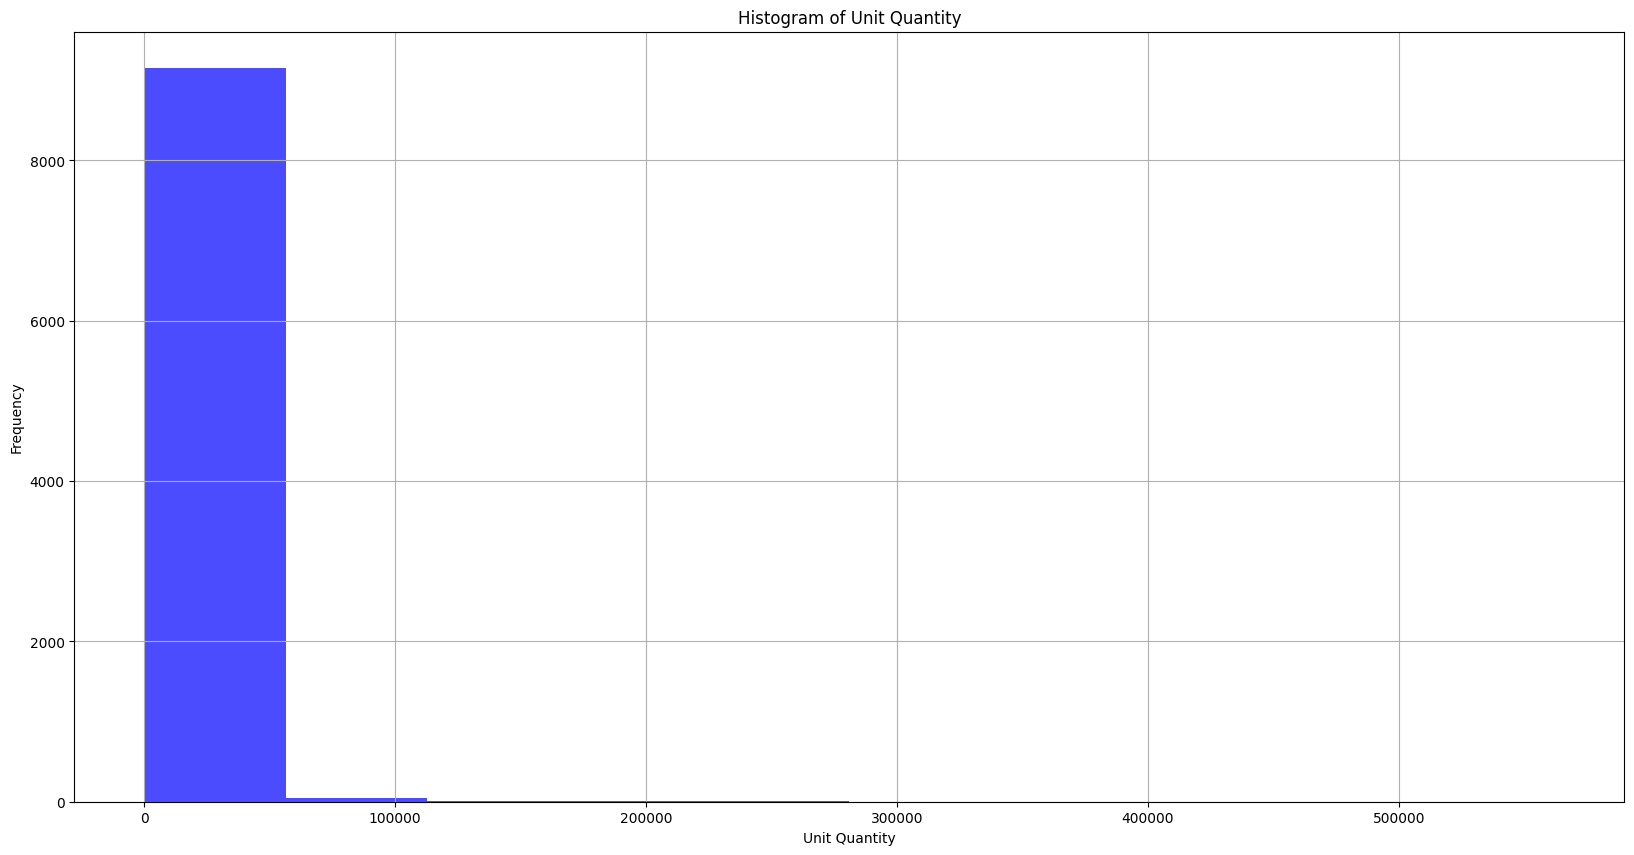

In [ ]:
# Create a histogram for unit_quantity
plt.figure(figsize=(20, 10))
pd_ol_2['unit_quantity'].plot.hist(bins=10, color='blue', alpha=0.7)
plt.xlabel('Unit Quantity')
plt.ylabel('Frequency')
plt.title('Histogram of Unit Quantity')
plt.grid(True)
plt.show()

In [ ]:
# df_spark_ol_2
# df_spark_fr_2
# df_spark_whCosts_2
# df_spark_whCap_2
# df_spark_ppp_2
# df_spark_vc_2
# df_spark_plant_ports_2

# Order List Table
# Freight Rates Table
# ##### Weight Costs Table
# ##### Weight Capacities Table
# ##### Products Per Plant Table
# ##### Vendor Managed Inventory Customers Table
# ##### Plant Ports Table